# Projekt końcowy z Metod Numerycznych 2023/2024

- Mapka z suwakiem
- Prezentacja na 10 minut (muszą być slajdy, nie program,mapki, wykresy, podsumowania, tabele)
print(cities_weather_data["warszawa"])

## Zebranie danych

Użyto danych z biblioteki meteostat. Wybrano 5 lokalizacji: 
- Kraków
- Warszawa
- Wrocław
- Szczecin
- Gdańsk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meteostat import Point, Daily, units
from datetime import datetime

In [2]:
cities = {
    'Kraków': Point(50.0647, 19.9450),
    'Warszawa': Point(52.2297, 21.0122),
    'Wrocław': Point(51.1079, 17.0385),
    'Szczecin': Point(53.4285, 14.5528),
    'Gdańsk': Point(54.3520, 18.6466)
}

Dane pobrano z pierwszego kwartału 2024 roku

In [3]:
start = datetime(2024, 1, 1)
end = datetime(2024, 3, 31)

In [4]:
dataframes = []
for city, point in cities.items():
    data = Daily(point, start, end)
    data = data.fetch()
    data['City'] = city
    filename = f'{city.lower()}_weather_data.csv'
    data.to_csv(filename, index=True)
    print(f"Plik CSV dla {city} został pomyślnie wygenerowany jako {filename}.")

Plik CSV dla Kraków został pomyślnie wygenerowany jako kraków_weather_data.csv.


Plik CSV dla Warszawa został pomyślnie wygenerowany jako warszawa_weather_data.csv.


Plik CSV dla Wrocław został pomyślnie wygenerowany jako wrocław_weather_data.csv.


Plik CSV dla Szczecin został pomyślnie wygenerowany jako szczecin_weather_data.csv.


Plik CSV dla Gdańsk został pomyślnie wygenerowany jako gdańsk_weather_data.csv.


Dane zostały wygenerowane, zatem można przystąpić do obróbki danych

## Przygotowanie danych

In [5]:
def readData(name):
    ending = "_weather_data.csv"
    df = pd.read_csv(name + ending)
    return df

cities = ["kraków", "gdańsk", "szczecin", "warszawa", "wrocław"]

cities_weather_data = {city : readData(city) for city in cities}

for city, df in cities_weather_data.items():
    print(f"Weather data for {city}:")
    print(df.head(5))  

Weather data for kraków:
         time  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
0  2024-01-01   2.7   0.5   4.7   8.9   NaN  260.0  12.8  35.2  1009.2   NaN   
1  2024-01-02   4.9   2.9   7.0   9.9   NaN  193.0   9.7  29.6  1008.0   NaN   
2  2024-01-03   7.4   4.1  10.2   5.5   NaN  223.0  19.2  44.5   997.5   NaN   
3  2024-01-04   6.6   3.1   9.2   7.1   NaN  235.0  25.5  53.7   998.6   NaN   
4  2024-01-05   1.3   0.0   6.5   5.8   NaN   25.0  14.4  46.3  1009.8   NaN   

     City  
0  Kraków  
1  Kraków  
2  Kraków  
3  Kraków  
4  Kraków  
Weather data for gdańsk:
         time  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
0  2024-01-01   1.9   1.0   3.0   2.2   NaN  161.0  10.4  22.2  1004.6   NaN   
1  2024-01-02   1.5   0.0   3.0   2.0   NaN   92.0   9.9  24.1  1003.2   NaN   
2  2024-01-03  -1.8  -4.0   0.0  19.1   NaN   98.0  19.5  27.8   992.8   NaN   
3  2024-01-04  -3.8  -4.0  -3.0   7.6   NaN   40.0  15.3  31.5   993.3   NaN 

W tym datasecie występuje 10 zmiennych dotyczących pogody. Ograniczmy go do 4: temperatury, ciśnienia atmosferycznego, sumy opadów i prędkości wiatru

Należy usunąć pozostałe kolumny

In [6]:
def removeSomeCols(df):
    df = df.drop(['tmin', 'tmax', 'snow', 'wdir', 'wpgt', 'tsun'], axis = 1)
    return df

for city in cities_weather_data:
    cities_weather_data[city] = removeSomeCols(cities_weather_data[city])
    print(city)
    print(cities_weather_data[city])

kraków
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   2.7   8.9  12.8  1009.2  Kraków
1   2024-01-02   4.9   9.9   9.7  1008.0  Kraków
2   2024-01-03   7.4   5.5  19.2   997.5  Kraków
3   2024-01-04   6.6   7.1  25.5   998.6  Kraków
4   2024-01-05   1.3   5.8  14.4  1009.8  Kraków
..         ...   ...   ...   ...     ...     ...
86  2024-03-27  10.9   0.0  14.0   997.9  Kraków
87  2024-03-28  12.3  11.0  15.1   994.6  Kraków
88  2024-03-29  11.7   1.7  13.5  1006.8  Kraków
89  2024-03-30  15.6   0.0   8.5  1006.3  Kraków
90  2024-03-31  17.9   0.0  12.7  1003.6  Kraków

[91 rows x 6 columns]
gdańsk
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   1.9   2.2  10.4  1004.6  Gdańsk
1   2024-01-02   1.5   2.0   9.9  1003.2  Gdańsk
2   2024-01-03  -1.8  19.1  19.5   992.8  Gdańsk
3   2024-01-04  -3.8   7.6  15.3   993.3  Gdańsk
4   2024-01-05  -5.7   0.0  12.9  1007.5  Gdańsk
..         ...   ...   ...   ...     ...     ...
86  2024-03-27   9.4   0.0  21.5

- tavg - średnia temperatura powietrza [°C]
- wspd - średnia prędkość wiatru [km/h]
- pres - średnie ciśnienie atmosferyczne [hPa]
- prcp - średnia suma opadów [mm]

In [7]:
def shape(df):
    print(df.shape)

for city in cities_weather_data:
    shape(cities_weather_data[city])
    print(city)
    print(cities_weather_data[city])

(91, 6)
kraków
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   2.7   8.9  12.8  1009.2  Kraków
1   2024-01-02   4.9   9.9   9.7  1008.0  Kraków
2   2024-01-03   7.4   5.5  19.2   997.5  Kraków
3   2024-01-04   6.6   7.1  25.5   998.6  Kraków
4   2024-01-05   1.3   5.8  14.4  1009.8  Kraków
..         ...   ...   ...   ...     ...     ...
86  2024-03-27  10.9   0.0  14.0   997.9  Kraków
87  2024-03-28  12.3  11.0  15.1   994.6  Kraków
88  2024-03-29  11.7   1.7  13.5  1006.8  Kraków
89  2024-03-30  15.6   0.0   8.5  1006.3  Kraków
90  2024-03-31  17.9   0.0  12.7  1003.6  Kraków

[91 rows x 6 columns]
(91, 6)
gdańsk
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   1.9   2.2  10.4  1004.6  Gdańsk
1   2024-01-02   1.5   2.0   9.9  1003.2  Gdańsk
2   2024-01-03  -1.8  19.1  19.5   992.8  Gdańsk
3   2024-01-04  -3.8   7.6  15.3   993.3  Gdańsk
4   2024-01-05  -5.7   0.0  12.9  1007.5  Gdańsk
..         ...   ...   ...   ...     ...     ...
86  2024-03-27  

Mamy do przeanalizowania łącznie 91 wierszy

In [8]:
def printInfo(df):
    print(df.info())

for city in cities_weather_data:
    printInfo(cities_weather_data[city])
    print(city)
    print(cities_weather_data[city])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    91 non-null     object 
 1   tavg    91 non-null     float64
 2   prcp    91 non-null     float64
 3   wspd    91 non-null     float64
 4   pres    91 non-null     float64
 5   City    91 non-null     object 
dtypes: float64(4), object(2)
memory usage: 4.4+ KB
None
kraków
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   2.7   8.9  12.8  1009.2  Kraków
1   2024-01-02   4.9   9.9   9.7  1008.0  Kraków
2   2024-01-03   7.4   5.5  19.2   997.5  Kraków
3   2024-01-04   6.6   7.1  25.5   998.6  Kraków
4   2024-01-05   1.3   5.8  14.4  1009.8  Kraków
..         ...   ...   ...   ...     ...     ...
86  2024-03-27  10.9   0.0  14.0   997.9  Kraków
87  2024-03-28  12.3  11.0  15.1   994.6  Kraków
88  2024-03-29  11.7   1.7  13.5  1006.8  Kraków
89  2024-03-30  15.6   0.0   8.5  1006.3  Kraków

In [9]:
def isNa(df):
    print(df.isna().sum())

for city in cities_weather_data:
    isNa(cities_weather_data[city])
    print(city)
    print(cities_weather_data[city])

time    0
tavg    0
prcp    0
wspd    0
pres    0
City    0
dtype: int64
kraków
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   2.7   8.9  12.8  1009.2  Kraków
1   2024-01-02   4.9   9.9   9.7  1008.0  Kraków
2   2024-01-03   7.4   5.5  19.2   997.5  Kraków
3   2024-01-04   6.6   7.1  25.5   998.6  Kraków
4   2024-01-05   1.3   5.8  14.4  1009.8  Kraków
..         ...   ...   ...   ...     ...     ...
86  2024-03-27  10.9   0.0  14.0   997.9  Kraków
87  2024-03-28  12.3  11.0  15.1   994.6  Kraków
88  2024-03-29  11.7   1.7  13.5  1006.8  Kraków
89  2024-03-30  15.6   0.0   8.5  1006.3  Kraków
90  2024-03-31  17.9   0.0  12.7  1003.6  Kraków

[91 rows x 6 columns]
time    0
tavg    0
prcp    0
wspd    0
pres    0
City    0
dtype: int64
gdańsk
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   1.9   2.2  10.4  1004.6  Gdańsk
1   2024-01-02   1.5   2.0   9.9  1003.2  Gdańsk
2   2024-01-03  -1.8  19.1  19.5   992.8  Gdańsk
3   2024-01-04  -3.8   7.6  15.3 

W datasecie nie występują braki, dlatego aby móc użyć metod numerycznych i sprawdzić ich efektywność, należy niektóre wartości usunąć 

In [10]:
def randomly_remove_values(df, frac, columns_to_nan):
    total_elements = df[columns_to_nan].size
    num_elements_to_remove = int(total_elements * frac)
    indices = [(row, df.columns.get_loc(col)) for row in range(df.shape[0]) for col in columns_to_nan]
    indices_to_remove = np.random.choice(range(len(indices)), num_elements_to_remove, replace=False)

    for index in indices_to_remove:
        row, col = indices[index]
        df.iat[row, col] = np.nan
    
    return df


cities_weather_data_nans = cities_weather_data.copy()

columns_to_nan = ['tavg', 'prcp', 'wspd', 'pres']
for city in cities_weather_data:
    cities_weather_data_nans[city] = randomly_remove_values(cities_weather_data_nans[city], 0.2, columns_to_nan)
    print(city)
    print(cities_weather_data_nans[city])

# columns_to_nan = ['tavg', 'prcp', 'wspd', 'pres']
# df_with_nan = randomly_remove_values(df.copy(), 0.2, columns_to_nan)
# df_with_nan.head()

kraków
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   2.7   8.9   NaN  1009.2  Kraków
1   2024-01-02   4.9   9.9   9.7  1008.0  Kraków
2   2024-01-03   7.4   5.5  19.2   997.5  Kraków
3   2024-01-04   6.6   7.1  25.5   998.6  Kraków
4   2024-01-05   1.3   NaN  14.4  1009.8  Kraków
..         ...   ...   ...   ...     ...     ...
86  2024-03-27  10.9   0.0   NaN     NaN  Kraków
87  2024-03-28  12.3  11.0  15.1   994.6  Kraków
88  2024-03-29  11.7   1.7  13.5  1006.8  Kraków
89  2024-03-30  15.6   0.0   8.5  1006.3  Kraków
90  2024-03-31  17.9   0.0  12.7  1003.6  Kraków

[91 rows x 6 columns]
gdańsk
          time  tavg  prcp  wspd    pres    City
0   2024-01-01   1.9   2.2  10.4  1004.6  Gdańsk
1   2024-01-02   NaN   NaN   9.9  1003.2  Gdańsk
2   2024-01-03  -1.8  19.1  19.5   992.8  Gdańsk
3   2024-01-04  -3.8   7.6   NaN   993.3  Gdańsk
4   2024-01-05  -5.7   0.0   NaN  1007.5  Gdańsk
..         ...   ...   ...   ...     ...     ...
86  2024-03-27   9.4   0.0  21.5

In [11]:
def isNa(df):
    print(df.isna().sum())

for city in cities_weather_data:
    isNa(cities_weather_data_nans[city])
    print(city)
    #print(cities_weather_data_nans[city])

time     0
tavg    17
prcp    16
wspd    22
pres    17
City     0
dtype: int64
kraków
time     0
tavg    16
prcp    17
wspd    22
pres    17
City     0
dtype: int64
gdańsk
time     0
tavg    14
prcp    23
wspd    17
pres    18
City     0
dtype: int64
szczecin
time     0
tavg    18
prcp    17
wspd    22
pres    15
City     0
dtype: int64
warszawa
time     0
tavg    17
prcp    18
wspd    18
pres    19
City     0
dtype: int64
wrocław


## Obliczanie brakujących danych

Uzupełnijmy braki za pomocą metod numerycznych. W tym przypadku najlepsza będzie aproksymacja, ponieważ nie chcemy, żeby funkcje przechodziły dokładnie przez wszystkie anomalie, ale żeby zwracały uśrednioną wartość

Aby umożliwić przeprowadzenie interpolacji, dodajmy kolumnę 'number', która będzie odpowiadać węzłom interpolacji

In [12]:
def addColumn(df):
    number_of_rows = len(df['time'])
    natural_numbers = list(range(1, number_of_rows + 1))
    df['number'] = natural_numbers

#print(x)
for city in cities_weather_data_nans:
    addColumn(cities_weather_data_nans[city])
    print(city)
    print(cities_weather_data_nans[city])


kraków
          time  tavg  prcp  wspd    pres    City  number
0   2024-01-01   2.7   8.9   NaN  1009.2  Kraków       1
1   2024-01-02   4.9   9.9   9.7  1008.0  Kraków       2
2   2024-01-03   7.4   5.5  19.2   997.5  Kraków       3
3   2024-01-04   6.6   7.1  25.5   998.6  Kraków       4
4   2024-01-05   1.3   NaN  14.4  1009.8  Kraków       5
..         ...   ...   ...   ...     ...     ...     ...
86  2024-03-27  10.9   0.0   NaN     NaN  Kraków      87
87  2024-03-28  12.3  11.0  15.1   994.6  Kraków      88
88  2024-03-29  11.7   1.7  13.5  1006.8  Kraków      89
89  2024-03-30  15.6   0.0   8.5  1006.3  Kraków      90
90  2024-03-31  17.9   0.0  12.7  1003.6  Kraków      91

[91 rows x 7 columns]
gdańsk
          time  tavg  prcp  wspd    pres    City  number
0   2024-01-01   1.9   2.2  10.4  1004.6  Gdańsk       1
1   2024-01-02   NaN   NaN   9.9  1003.2  Gdańsk       2
2   2024-01-03  -1.8  19.1  19.5   992.8  Gdańsk       3
3   2024-01-04  -3.8   7.6   NaN   993.3  Gdańsk   

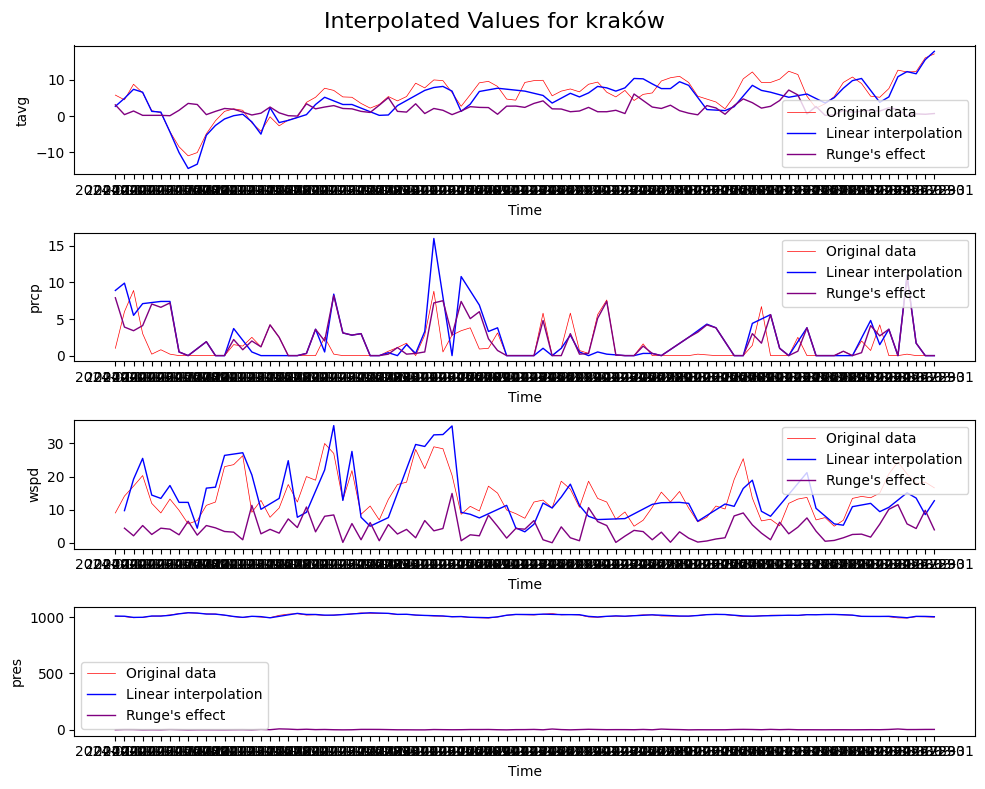

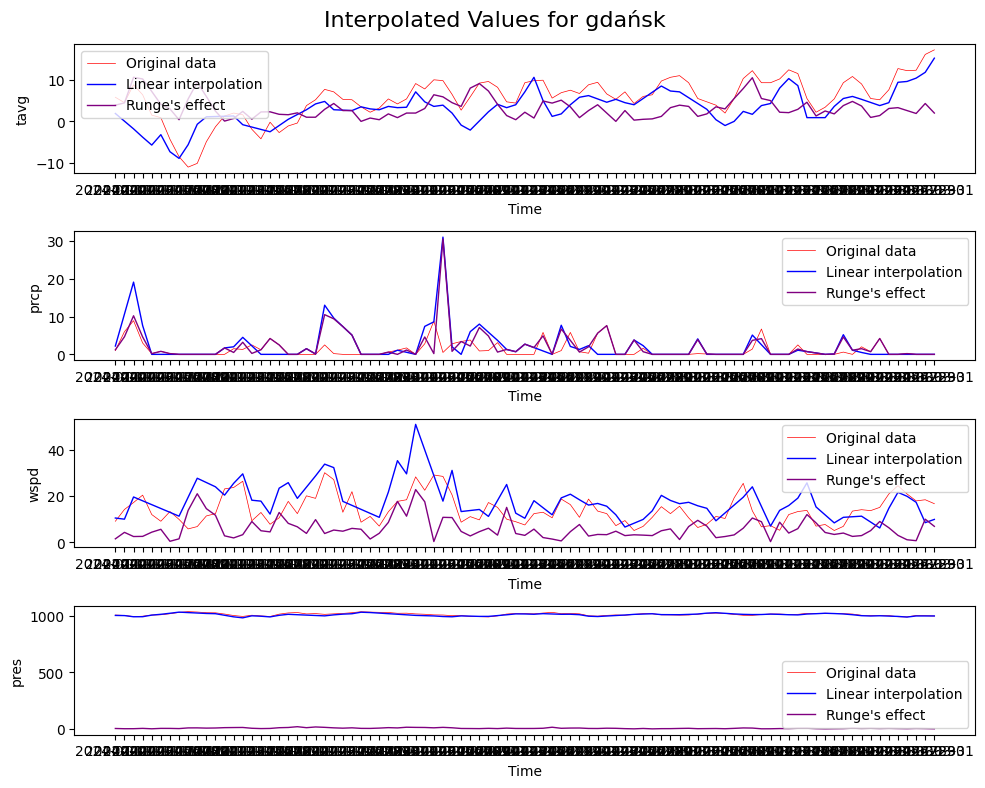

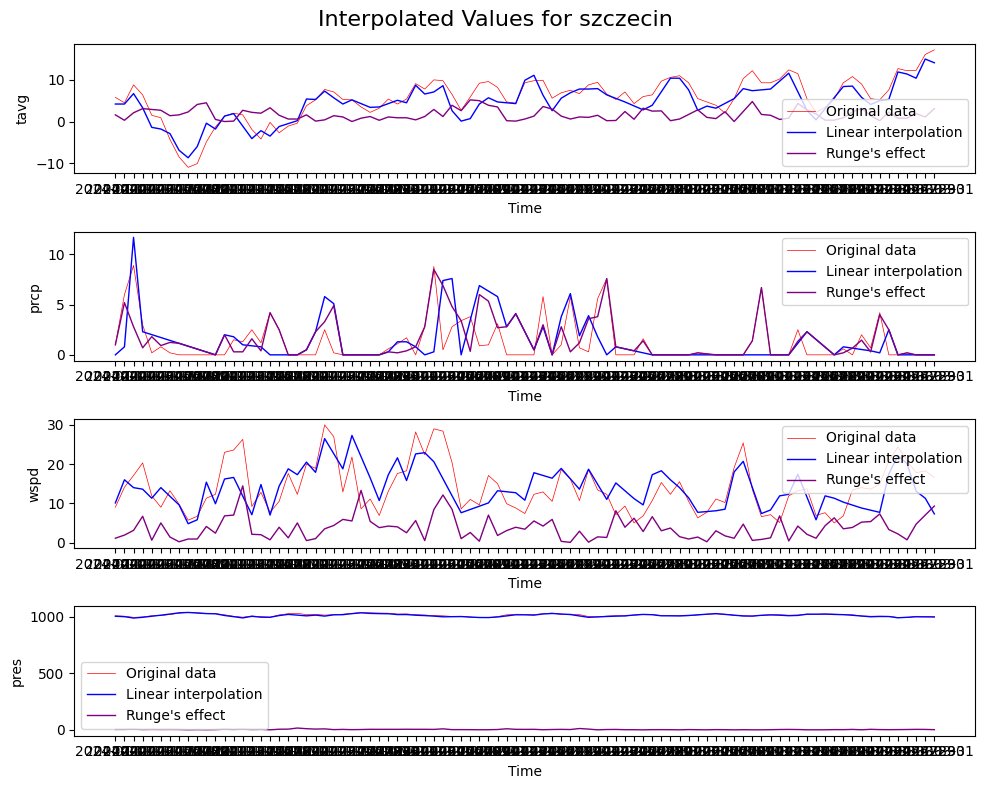

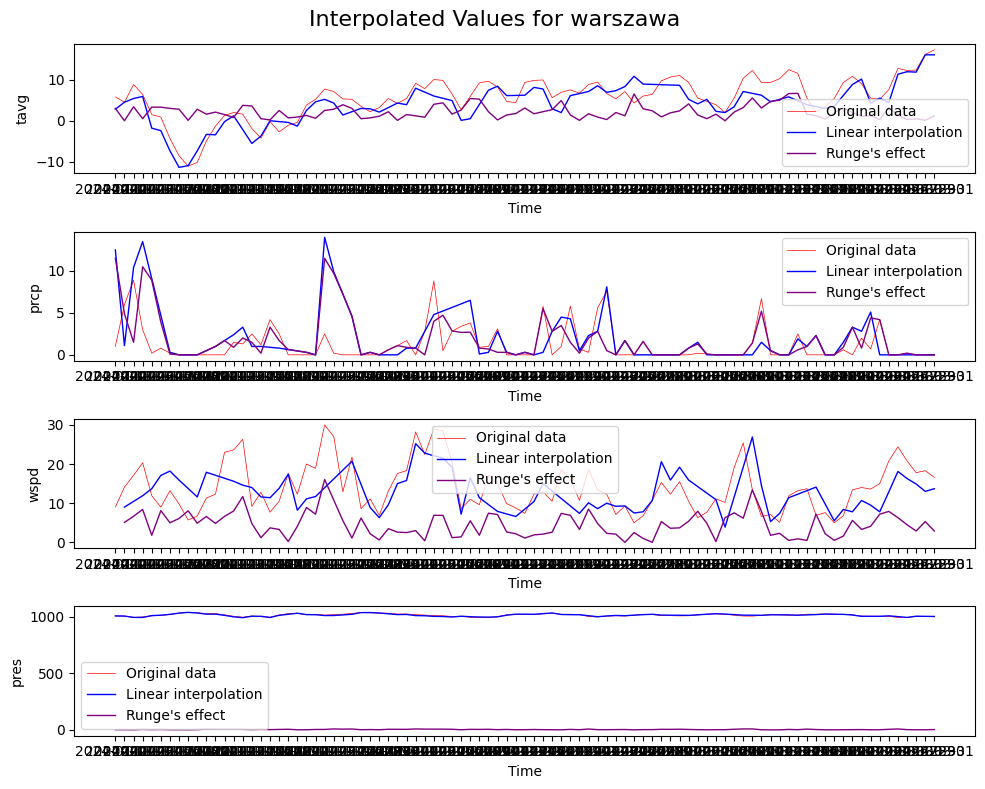

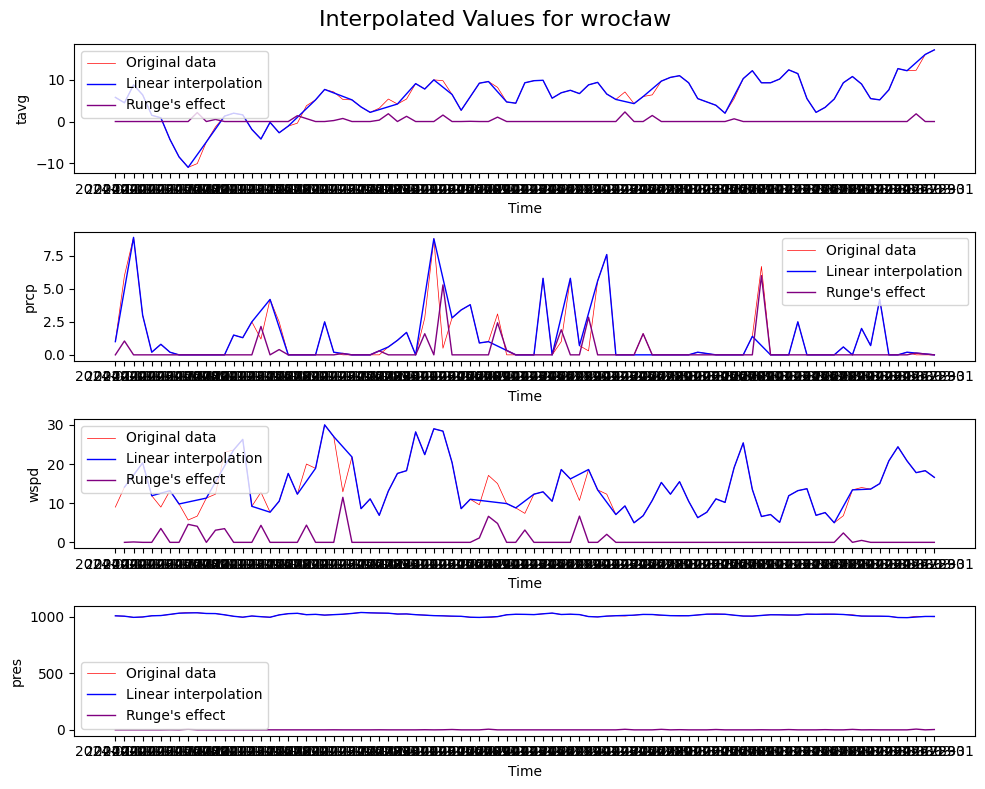

In [13]:
for city in cities_weather_data_nans:
    num_plots = len([col for col in cities_weather_data_nans[city].columns if col not in ['time', 'City', 'number']])
    fig, axs = plt.subplots(num_plots, figsize=(10, 8))
    fig.suptitle(f'Interpolated Values for {city}', fontsize=16)

    plot_counter = 0
    for i, column in enumerate(cities_weather_data_nans[city].columns):
        if column not in ['time', 'City', 'number']:
            # Original data from df
            axs[plot_counter].plot(df['time'], df[column], linestyle='-', color='red', linewidth=0.5, label='Original data')
            axs[plot_counter].set_xlabel('Time')
            axs[plot_counter].set_ylabel(column)

            # Linear interpolation
            linear_interpolated_values = cities_weather_data_nans[city][column].interpolate(method='linear')
            axs[plot_counter].plot(cities_weather_data_nans[city]['time'], linear_interpolated_values, linestyle='-', color='blue', linewidth=1, label='Linear interpolation')

            # Highlight Runge's phenomenon
            runge_effect = abs(linear_interpolated_values - df[column])
            axs[plot_counter].plot(cities_weather_data_nans[city]['time'], runge_effect, linestyle='-', color='purple', linewidth=1, label="Runge's effect")

            # Add legend
            axs[plot_counter].legend()

            plot_counter += 1
            if plot_counter >= num_plots:
                break

    plt.tight_layout()
    plt.show()

In [14]:
import numpy as np
import pandas as pd

def oblicz_roznice_dzielone(wartoscX, wartoscY):
    n = len(wartoscX)
    tabela = np.zeros((n, n))
    tabela[:, 0] = wartoscY
    
    for j in range(1, n):
        for i in range(n - j):
            tabela[i, j] = (tabela[i + 1, j - 1] - tabela[i, j - 1]) / (wartoscX[i + j] - wartoscX[i])
    
    wspolczynniki = tabela[0, :n]
    return wspolczynniki

def wartosc_wielomianu_newtona(wspolczynniki, wartoscX, x):
    n = len(wspolczynniki)
    wynik = wspolczynniki[0]
    
    for i in range(1, n):
        iloczyn = 1
        for j in range(i):
            iloczyn *= (x - wartoscX[j])
        wynik += wspolczynniki[i] * iloczyn
    
    return wynik

def interpolateAllColumns(df):
    columns = ["tavg", "prcp", "wspd", "pres"]
    for column in columns:

        valid_mask = df[column].notna()
        wezelX = df['number'][valid_mask].values
        wezelY = df[column][valid_mask].values


        coef = oblicz_roznice_dzielone(wezelX, wezelY)

        for i in df.index[df[column].isna()]:
            x = df.at[i, 'number']
            df.at[i, column] = wartosc_wielomianu_newtona(coef, wezelX, x)

# Kopia dataframe
cities_weather_data_nans_copy = cities_weather_data_nans.copy()

# for city in cities_weather_data_nans_copy:
#     interpolateAllColumns(cities_weather_data_nans_copy[city])
#     print(city)
#     print(cities_weather_data_nans_copy[city])




#Aproksymacja średniokwadratowa
def dziesieciowezlowa_kwadratura_GL(funkcja, a, b):
    factor1 = (b - a) / 2.0
    factor2 = (b + a) / 2.0
    points = [-0.973906528517172, -0.865063366688985, -0.679409568299024, -0.433395394129247, -0.148874338981631, 
              0.148874338981631, 0.433395394129247, 0.679409568299024, 0.865063366688985, 0.973906528517172]
    weights = [0.066671344308688, 0.149451349150581, 0.219086362515982, 0.269266719309996, 0.295524224714753, 
               0.295524224714753, 0.269266719309996, 0.219086362515982, 0.149451349150581, 0.066671344308688]
    wynik = sum(weights[i] * funkcja(factor2 + factor1 * points[i]) for i in range(10))
    return factor1 * wynik

def rozklad_LU(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))

    for i in range(n):
        for k in range(i, n):
            suma = sum(L[i, j] * U[j, k] for j in range(i))
            U[i, k] = A[i, k] - suma

        for k in range(i, n):
            if i == k:
                L[i, i] = 1
            else:
                suma = sum(L[k, j] * U[j, i] for j in range(i))
                L[k, i] = (A[k, i] - suma) / U[i, i]
                
    return L, U

def rozwiaz_LU(L, U, B):
    n = L.shape[0]
    z = np.zeros(n)
    x = np.zeros(n)

    for i in range(n):
        suma = B[i] - sum(L[i, j] * z[j] for j in range(i))
        z[i] = suma / L[i, i]

    for i in range(n-1, -1, -1):
        suma = z[i] - sum(U[i, j] * x[j] for j in range(i+1, n))
        x[i] = suma / U[i, i]

    return x

# Aproksymacja średniokwadratowa
def aproksymacja_sredniokwadratowa(wezelX, wezelY, degree):
    A = np.vander(wezelX, degree + 1)
    L, U = rozklad_LU(np.dot(A.T, A))
    wspolczynniki = rozwiaz_LU(L, U, np.dot(A.T, wezelY))
    return wspolczynniki

# Uzupełnianie brakujących wartości za pomocą aproksymacji średniokwadratowej
def wartosc_wielomianu(wspolczynniki, x):
    return np.polyval(wspolczynniki, x)

def aproxAllColumns(df):
    degree = 3
    columns = ["tavg", "prcp", "wspd", "pres"]
    for column in columns:

        valid_mask = df[column].notna()
        wezelX = df['number'][valid_mask].values
        wezelY = df[column][valid_mask].values

        coef = aproksymacja_sredniokwadratowa(wezelX, wezelY, degree)


        for i in df.index[df[column].isna()]:
            x = df.at[i, 'number']
            df.at[i, column] = wartosc_wielomianu(coef, x)

for city in cities_weather_data_nans:
    aproxAllColumns(cities_weather_data_nans[city])
    print(city)
    print(cities_weather_data_nans[city])


def saveData(df, name):
    filename = f"{name}_weather_data_final.csv"
    df.to_csv(filename, index=False)
    print(f"Plik CSV dla {name} został pomyślnie zapisany jako {filename}.")
    return df


# degree = 3
# wspolczynniki_approx = aproksymacja_sredniokwadratowa(wezelX, wezelY, degree)



# Uzupełnianie brakujących wartości w dataframe
# for i in df_copy.index:
#     if pd.isna(df_copy.at[i, 'tavg']):
#         x = df_copy.at[i, 'number']
#         df_copy.at[i, 'tavg'] = wartosc_wielomianu(wspolczynniki_approx, x)

# Tworzenie finalnego dataframe i wstawianie wartości
# df_final = df_with_nan.copy()
# df_final['tavg'] = df_copy['tavg']

# df_final.to_csv('df_final.csv', index=False)

kraków
          time  tavg       prcp       wspd         pres    City  number
0   2024-01-01   2.7   8.900000  13.649118  1009.200000  Kraków       1
1   2024-01-02   4.9   9.900000   9.700000  1008.000000  Kraków       2
2   2024-01-03   7.4   5.500000  19.200000   997.500000  Kraków       3
3   2024-01-04   6.6   7.100000  25.500000   998.600000  Kraków       4
4   2024-01-05   1.3   5.016159  14.400000  1009.800000  Kraków       5
..         ...   ...        ...        ...          ...     ...     ...
86  2024-03-27  10.9   0.000000  11.857012  1009.975247  Kraków      87
87  2024-03-28  12.3  11.000000  15.100000   994.600000  Kraków      88
88  2024-03-29  11.7   1.700000  13.500000  1006.800000  Kraków      89
89  2024-03-30  15.6   0.000000   8.500000  1006.300000  Kraków      90
90  2024-03-31  17.9   0.000000  12.700000  1003.600000  Kraków      91

[91 rows x 7 columns]
gdańsk
          time      tavg       prcp       wspd         pres    City  number
0   2024-01-01   1.9000

## Wizualizacja danych

Wykres przedstawiający rozkład modelowych danych meteorologicznych w Krakowie

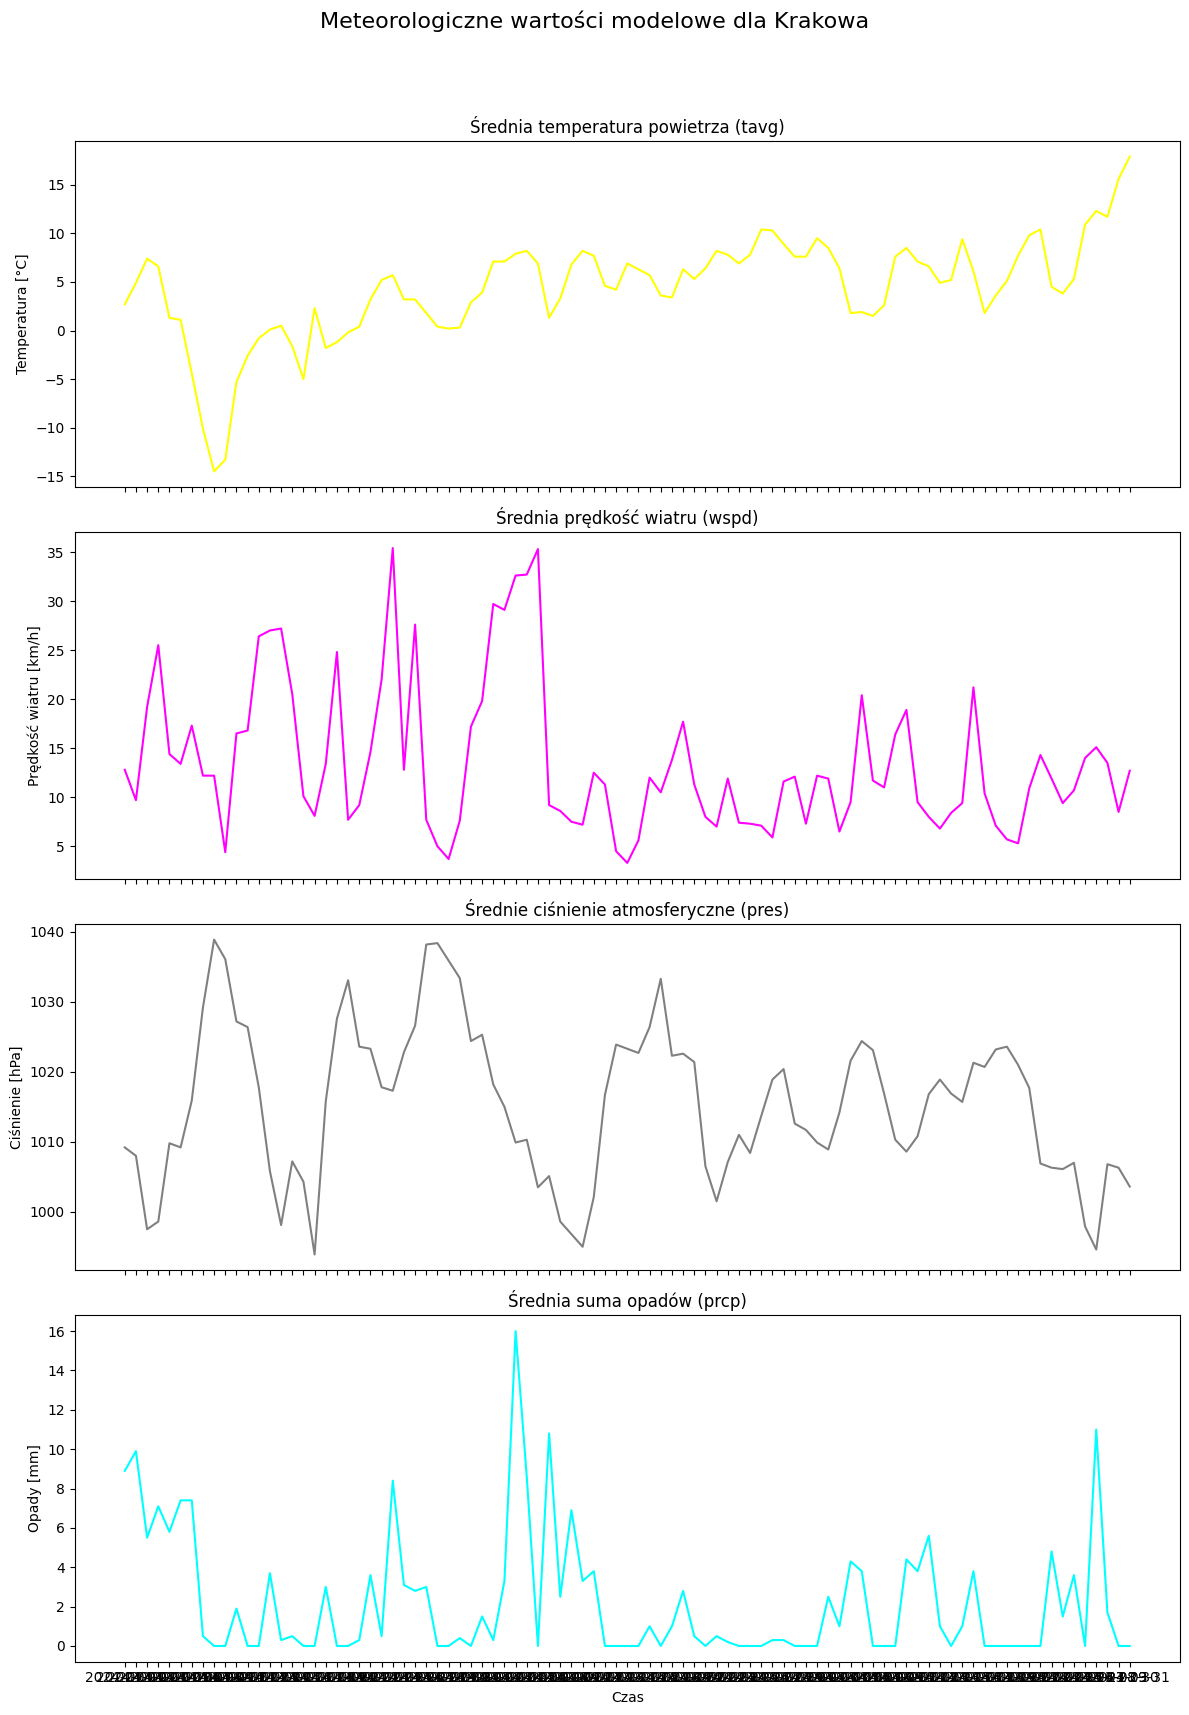

In [15]:
file_path = 'kraków_weather_data.csv'
weather_data = pd.read_csv(file_path)

fig, axs = plt.subplots(4, 1, figsize=(12, 18), sharex=True)

axs[0].plot(weather_data['time'], weather_data['tavg'], color='yellow')
axs[0].set_title('Średnia temperatura powietrza (tavg)')
axs[0].set_ylabel('Temperatura [°C]')

axs[1].plot(weather_data['time'], weather_data['wspd'], color='magenta')
axs[1].set_title('Średnia prędkość wiatru (wspd)')
axs[1].set_ylabel('Prędkość wiatru [km/h]')

axs[2].plot(weather_data['time'], weather_data['pres'], color='gray')
axs[2].set_title('Średnie ciśnienie atmosferyczne (pres)')
axs[2].set_ylabel('Ciśnienie [hPa]')

axs[3].plot(weather_data['time'], weather_data['prcp'], color='cyan')
axs[3].set_title('Średnia suma opadów (prcp)')
axs[3].set_ylabel('Opady [mm]')
axs[3].set_xlabel('Czas')

fig.suptitle('Meteorologiczne wartości modelowe dla Krakowa', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Wykres przedstawiający rozkład zaproksymowanych danych meteorologicznych w Krakowie

Wykres przedstawiający błąd bezwzględny pomiędzy danymi modelowymi a zaproksymowanymi